# Analyze and plot methods for hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0
##### date: 14 December 2021

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model
from custom_loss import compute_shash_NLL, compute_NLL
from custom_metrics import CustomMAE, InterquartileCapture, SignTest
from model_diagnostics import plot_history
from save_model_run import save_model_run
from sklearn import preprocessing
from tensorflow.keras import optimizers
from training_instrumentation import TrainingInstrumentation
from silence_tensorflow import silence_tensorflow
import tensorflow_probability as tfp

from tqdm import tqdm

silence_tensorflow()

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "15 December 2021"

# EXP_NAME_LIST = ("intensity0_AL72","intensity1_AL72")
# EXP_NAME_LIST = ("intensity2_EPCP48","intensity3_EPCP48")
EXP_NAME_LIST = ("intensity2_EPCP48","intensity7_EPCP48")
# EXP_NAME_LIST = ("intensity4_EPCP72","intensity5_EPCP72")

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load the models

In [4]:
for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    # pprint.pprint(settings, width=80)
    
    NETWORK_SEED_LIST = [settings["rng_seed"]]
    network_seed = NETWORK_SEED_LIST[0]
    tf.random.set_seed(network_seed)  # This sets the global random seed.    
    
    (x_train,
        onehot_train,
        x_val,
        onehot_val,
        data_summary,
        df,
    ) = build_hurricane_data(DATA_PATH, settings, verbose=0)    

    if settings["uncertainty_type"] == "bnn":       
        model_name_bnn = (
            exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        pprint.pprint(model_name_bnn)
        
        model_bnn = build_bnn_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_bnn.load_weights(MODEL_PATH + model_name_bnn + "_weights.h5")

    elif settings["uncertainty_type"][:5] == "shash": 
        model_name_shash = (
            exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        pprint.pprint(model_name_shash)
        
        model_shash = build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_shash.load_weights(MODEL_PATH + model_name_shash + "_weights.h5")
        
    


'intensity2_EPCP48_shash3_network_seed_999_rng_seed_999'
'intensity7_EPCP48_bnn_network_seed_999_rng_seed_999'


/Users/eabarnes/opt/anaconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/opt/anaconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


## Make Model Predictions

In [5]:
runs = 5_000
x_incs = np.arange(-100,110,1)
shash_cpd = np.zeros((np.shape(x_val)[0],len(x_incs)))
shash_med = np.zeros((np.shape(x_val)[0],))
bnn_cpd = np.zeros((np.shape(x_val)[0],runs))
tf.random.set_seed(network_seed)

# loop through samples for shash calculation and get PDF for each sample
for j in tqdm(range(0,np.shape(shash_cpd)[0])):
    shash_pred = model_shash.predict(x_val[j])
    (mu_pred, sigma_pred, gamma_pred) = (shash_pred[:,0], shash_pred[:,1], shash_pred[:,2])
    shash_cpd[j,:] = shash.prob(x_incs,mu_pred,sigma_pred,gamma_pred,np.ones(np.shape(mu_pred)))
    shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,np.ones(np.shape(mu_pred)))
    
# loop through runs for bnn calculation    
for i in tqdm(range(0,runs)):
    bnn_cpd[:,i] = np.reshape(model_bnn.predict(x_val),np.shape(bnn_cpd)[0])
     

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:24<00:00, 24.48it/s]


## Plot Results

In [6]:
clr_shash = 'teal'
clr_bnn   = 'orange'
clr_truth = 'dimgray'

dpiFig = 400

In [7]:
### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([]) 

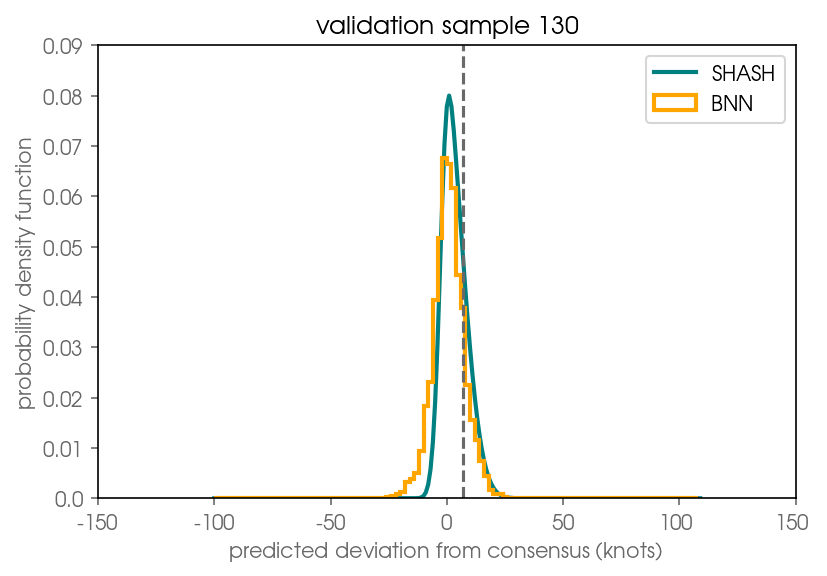

In [8]:
# PLOT RESULTS    
sample = 130
bins = np.arange(-100,110,2)

ax = plt.figure()
# results for SHASH
plt.plot(x_incs,
         shash_cpd[sample,:],
         color=clr_shash,
         linewidth=2,
         label='SHASH',
        )

# results for BNN
plt.hist(bnn_cpd[sample,:],
         bins=bins,
         histtype=u'step',
         density=True, 
         color=clr_bnn,
         linewidth=2,
         label='BNN',
        )

# truth
plt.axvline(x=onehot_val[sample,0],color=clr_truth,linestyle='--')
    
plt.legend()

ax = plt.gca()
xticks = ax.get_xticks()
yticks = np.around(ax.get_yticks(),3)
plt.xticks(xticks.astype(int),xticks.astype(int))
plt.yticks(yticks,yticks)

plt.title('validation sample ' + str(sample))
plt.xlabel('predicted deviation from consensus (knots)')
plt.ylabel('probability density function')

plt.savefig('figures/prediction_plots/' + model_name_shash + '_' + model_name_bnn + '_sample' + str(sample) + '.png', dpi=dpiFig)    
plt.show()

## Compare log-likelihoods

In [9]:
# SHASH LOG-LIKELIHOOD COMPUTATION
shash_pred = model_shash.predict(x_val)
mu = shash_pred[:,0]
sigma = shash_pred[:,1]
gamma = shash_pred[:,2]
tau = np.ones(np.shape(mu))
shash_nloglike = -shash.log_prob(onehot_val[:,0], mu, sigma, gamma, tau)

# BNN LOG-LIKELIHOOD COMPUTATION
bins_inc = 2
bins = np.arange(-100,110,bins_inc)
bnn_nloglike = np.zeros((np.shape(bnn_cpd)[0],))
for sample in np.arange(0,np.shape(bnn_cpd)[0]):
    hist_bnn = np.histogram(bnn_cpd[sample,:],
                            bins
                           )
    i = np.argmin(np.abs( (bins+bins_inc/2) - onehot_val[sample,0]))
    if(hist_bnn[0][i]==0):
        print('---sample ' + str(sample) + ' negative-log-likelihood being set to NaN due to log(0) issues')
        bnn_nloglike[sample] = np.nan
    else:
        bnn_nloglike[sample] = -np.log(hist_bnn[0][i]/(bins_inc*np.sum(hist_bnn[0])))

# print(shash_nloglike[sample].numpy(),bnn_nloglike[sample])
print('\n')
print('SHASH mean negative log-likelihood: ' + str(np.round(np.nanmean(shash_nloglike.numpy()),3)))
print('BNN   mean negative log-likelihood: ' + str(np.round(np.nanmean(bnn_nloglike),3)))

---sample 349 negative-log-likelihood being set to NaN due to log(0) issues


SHASH mean negative log-likelihood: 4.025
BNN   mean negative log-likelihood: 4.135


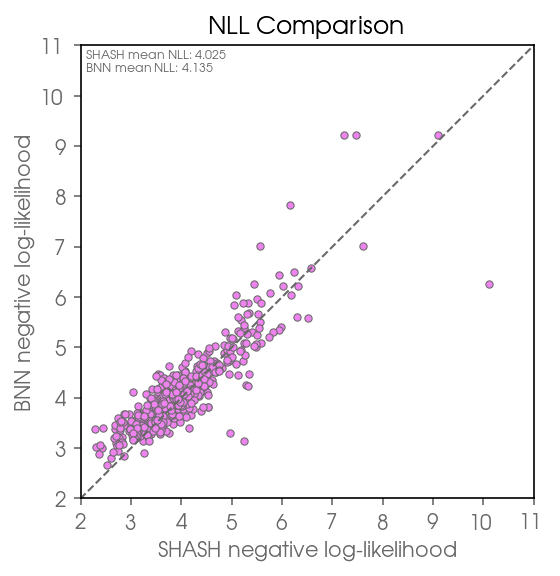

In [10]:
plt.figure()
plt.plot(shash_nloglike.numpy(),
         bnn_nloglike,
         linestyle='None',
         marker='.',
         color='dimgray',
         markerfacecolor='violet',
         markersize=7,
         markeredgewidth=.5,
        )


plt.xlabel('SHASH negative log-likelihood')
plt.ylabel('BNN negative log-likelihood')

plt.plot((-100,100),(-100,100),'--',color='dimgray', linewidth=1.)
plt.axis('scaled')
plt.xlim(2,11)
plt.ylim(2,11)

ax = plt.gca()
xticks = ax.get_xticks()
yticks = ax.get_yticks()
plt.xticks(xticks.astype(int),xticks.astype(int))
plt.yticks(yticks.astype(int),yticks.astype(int))

plt.text(2.1,10.75,
         'SHASH mean NLL: ' + str(np.round(np.nanmean(shash_nloglike.numpy()),3)), 
         color='dimgray',         
         fontsize=6)
plt.text(2.1,10.5,
         'BNN mean NLL: ' + str(np.round(np.nanmean(bnn_nloglike),3)),
         color='dimgray',
         fontsize=6)

plt.title('NLL Comparison')

plt.savefig('figures/prediction_plots/' + model_name_shash + '_' + model_name_bnn + '_nll_vs_nll' + '.png', dpi=dpiFig)    
plt.show()

## Likelihood ratio test

p: 1.000000000000000000000000000000
p: 1.000000000000000000000000000000


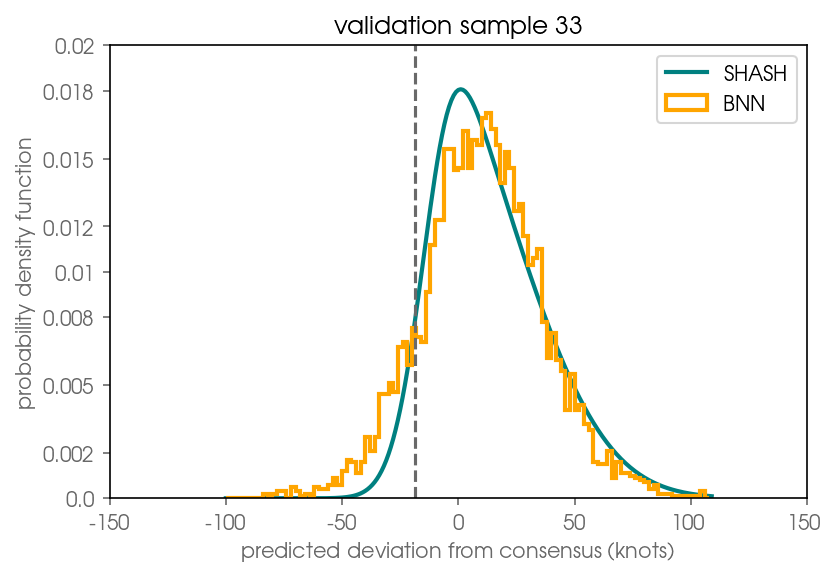

In [11]:
from scipy.stats.distributions import chi2

# PLOT RESULTS    
sample = 33 #87
bins = np.arange(-100,110,2)

ax = plt.figure()
# results for SHASH
plt.plot(x_incs,
         shash_cpd[sample,:],
         color=clr_shash,
         linewidth=2,
         label='SHASH',
        )

# results for BNN
plt.hist(bnn_cpd[sample,:],
         bins=bins,
         histtype=u'step',
         density=True, 
         color=clr_bnn,
         linewidth=2,
         label='BNN',
        )

# truth
plt.axvline(x=onehot_val[sample,0],color=clr_truth,linestyle='--')
    
plt.legend()

ax = plt.gca()
xticks = ax.get_xticks()
yticks = np.around(ax.get_yticks(),3)
plt.xticks(xticks.astype(int),xticks.astype(int))
plt.yticks(yticks,yticks)

plt.title('validation sample ' + str(sample))
plt.xlabel('predicted deviation from consensus (knots)')
plt.ylabel('probability density function')

def likelihood_ratio(log_like0, log_like1):
    return(-2*(log_like0 - log_like1))

# compute log likelihood test for an individual sample
L1 = -shash_nloglike.numpy()
L2 = -bnn_nloglike
LR = likelihood_ratio(L1,L2)
p = chi2.sf(LR, 1) # L2 has 1 DoF more than L1
print('p: %.30f' % p[sample])

# compute likelihood test on the MEAN log-likelihood
L1 = np.nanmean(-shash_nloglike.numpy())
L2 = np.nanmean(-bnn_nloglike)
LR = likelihood_ratio(L1,L2)
p = chi2.sf(LR, 1) # L2 has 1 DoF more than L1
print('p: %.30f' % p)


## Median vs Median

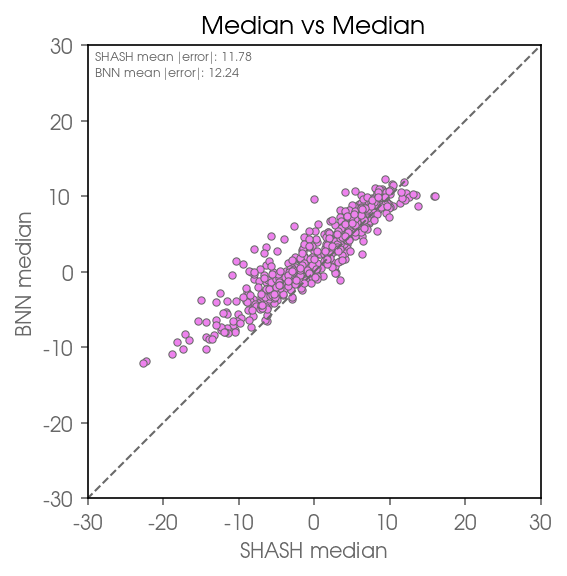

In [12]:
bnn_med = np.median(bnn_cpd,axis=1)
shash_error = np.mean(np.abs(shash_med - onehot_val[:,0]))
bnn_error = np.mean(np.abs(bnn_med - onehot_val[:,0]))


plt.figure()
plt.plot(shash_med,
         bnn_med,
         linestyle='None',
         marker='.',
         color='dimgray',
         markerfacecolor='violet',
         markersize=7,
         markeredgewidth=.5,
        )

plt.xlabel('SHASH median')
plt.ylabel('BNN median')

plt.plot((-100,100),(-100,100),'--',color='dimgray', linewidth=1.)
plt.axis('scaled')
plt.xlim(-25,25)
plt.ylim(-25,25)

ax = plt.gca()
xticks = ax.get_xticks()
yticks = ax.get_yticks()
plt.xticks(xticks.astype(int),xticks.astype(int))
plt.yticks(yticks.astype(int),yticks.astype(int))

plt.text(-29,28,
         'SHASH mean $|$error$|$: ' + str(np.round(shash_error,2)), 
         color='dimgray',         
         fontsize=6)
plt.text(-29,26,
         'BNN mean $|$error$|$: ' + str(np.round(bnn_error,2)), 
         color='dimgray',
         fontsize=6)

plt.title('Median vs Median')

plt.savefig('figures/prediction_plots/' + model_name_shash + '_' + model_name_bnn + '_median_vs_median' + '.png', dpi=dpiFig)    
plt.show()

## PIT Comparisons

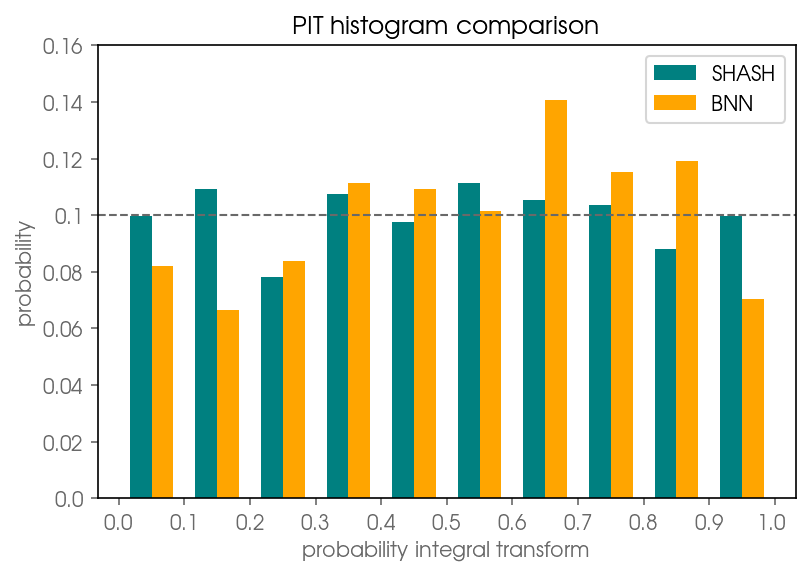

In [13]:
bins = np.linspace(0, 1, 11)
bins_inc = bins[1]-bins[0]


# SHASH PIT COMPUTATION
shash_pred = model_shash.predict(x_val)
mu = shash_pred[:,0]
sigma = shash_pred[:,1]
gamma = shash_pred[:,2]
tau = np.ones(np.shape(mu))
F = shash.cdf(onehot_val[:,0], mu, sigma, gamma, tau)
hist_shash = np.histogram(F,
                          bins,
                          weights=np.ones_like(F)/float(len(F)),
                         )
# plt.plot(hist_shash[1][:-1]+bins_inc/2,
#          hist_shash[0],
#          's-',         
#          color='tab:blue',
#          label='SHASH',
#         )
plt.bar(hist_shash[1][:-1]+bins_inc/6+bins_inc/6,
         hist_shash[0],
         width=bins_inc/3,
         color=clr_shash,
         label='SHASH',
        )



# BNN PIT COMPUTATION
bnn_cdf = np.zeros((np.shape(bnn_cpd)[0],)) 
for sample in np.arange(0,np.shape(bnn_cpd)[0]):
    i = np.where(onehot_val[sample,0]<bnn_cpd[sample,:])[0]
    bnn_cdf[sample] = len(i)/np.shape(bnn_cpd)[1]

hist_bnn = np.histogram(bnn_cdf,
                        bins,
                        weights=np.ones_like(bnn_cdf)/float(len(bnn_cdf)),
                       )
# plt.plot(hist_bnn[1][:-1]+bins_inc/2,
#          hist_bnn[0],
#          's-',
#          color='orange',
#          label='BNN',
#         )
plt.bar(hist_bnn[1][:-1]+3*bins_inc/6+bins_inc/6,
         hist_bnn[0],
         width=bins_inc/3,
         color=clr_bnn,
         label='BNN',
        )

# make the figure pretty
plt.axhline(y=.1, 
            linestyle='--',
            color='dimgray', 
            linewidth=1.,
           )

plt.xticks(bins,np.around(bins,1))
ax = plt.gca()
yticks = np.around(ax.get_yticks(),2)
plt.yticks(yticks,yticks)

plt.xlabel('probability integral transform')
plt.ylabel('probability')
plt.legend()
plt.title('PIT histogram comparison')

plt.savefig('figures/prediction_plots/' + model_name_shash + '_' + model_name_bnn + '_PITcomparison' + '.png', dpi=dpiFig)    
plt.show()

## Fraction between IQR

In [14]:
bins = np.linspace(0, 1, 11)
bins_inc = bins[1]-bins[0]

# SHASH PIT COMPUTATION
shash_pred = model_shash.predict(x_val)
mu = shash_pred[:,0]
sigma = shash_pred[:,1]
gamma = shash_pred[:,2]
tau = np.ones(np.shape(mu))
F = shash.cdf(onehot_val[:,0], mu, sigma, gamma, tau)
i = np.where((0.25<=F) & (.75>=F))[0]
iqrfrac_shash = len(i)/len(F)

bnn_cdf = np.zeros((np.shape(bnn_cpd)[0],)) 
for sample in np.arange(0,np.shape(bnn_cpd)[0]):
    i = np.where(onehot_val[sample,0]<bnn_cpd[sample,:])[0]
    bnn_cdf[sample] = len(i)/np.shape(bnn_cpd)[1]
i = np.where((0.25<=bnn_cdf) & (0.75>=bnn_cdf))[0]
iqrfrac_bnn = len(i)/len(bnn_cdf)

print('SHASH IQR Fraction = ' + str(np.round(iqrfrac_shash,3)))
print('BNN   IQR Fraction = ' + str(np.round(iqrfrac_bnn,3)))

SHASH IQR Fraction = 0.506
BNN   IQR Fraction = 0.57
